# 2D Preprocessing the GlobColour Dataset 
* prepare dataset for LDS-fitting:
   * load all 5 variables and merge (interpolate) with the float dataset
   * load the distance to coast and merge (interpolate) with the float dataset
   * output the data on disk
   * (plan)if needed, split Nov-Dec, encoding the weekly number

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

In [42]:
# resampling frequency in number of days
freq=5

In [3]:
from tools.load_GlobColor_dataset import load_dataset
import importlib
importlib.reload(load_dataset)

<module 'tools.load_GlobColor_dataset.load_dataset' from '/Users/vyan2000/work_linux/2Archive/myproject/20161024xray_oceancolor/ocean_color-master/tools/load_GlobColor_dataset/load_dataset.py'>

In [4]:
############### CDM
ds_daily = load_dataset.load_cdm()


100%|██████████| 5536/5536 [01:08<00:00, 80.84it/s]


<xarray.Dataset>
Dimensions:   (lat: 553, lon: 721, time: 5536)
Coordinates:
  * lat       (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon       (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time      (time) datetime64[ns] 2002-04-28 2002-04-29 2002-04-30 ...
Data variables:
    CDM_mean  (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    Conventions:                CF-1.4
    title:                      GlobColour daily merged MERIS/SeaWiFS product
    product_name:               L3m_20020428__665648402_4_GSM-MERSWF_CDM_DAY_...
    product_type:               day
    product_version:            2016.1
    product_level:              3
    parameter_code:             CDM
    parameter:                  Coloured dissolved and detrital organic mater...
    parameter_algo_list:        GSM method
    publication:                Maritorena, S. and Siegel, D.A. 2005. Consist...
    site_name:                  665

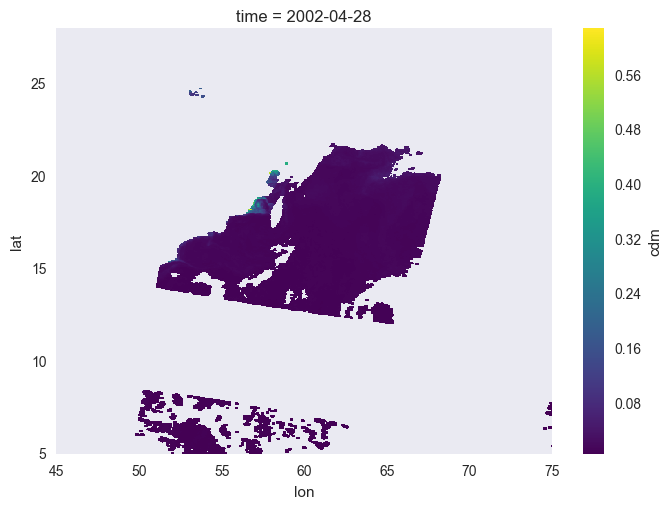

In [5]:
ds_daily.cdm.sel(time='2002-04-28').plot()

In [6]:
freq_resample = str(8) + 'D'
ds_8day = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_8day

<xarray.Dataset>
Dimensions:  (lat: 553, lon: 721, time: 695)
Coordinates:
  * lat      (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon      (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time     (time) datetime64[ns] 2002-04-28 2002-05-06 2002-05-14 ...
Data variables:
    cdm      (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

In [7]:
# check data quality
both_datasets = [ds_8day, ds_daily]
print([(ds.nbytes / 1e6) for ds in both_datasets])

[2216.854936, 17658.250728]


In [8]:
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are cdm values less than zero
    bad_data = ds.cdm.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.cdm[n].values 
        ds.cdm.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [9]:
[fix_bad_data(ds) for ds in both_datasets]

[None, None]

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


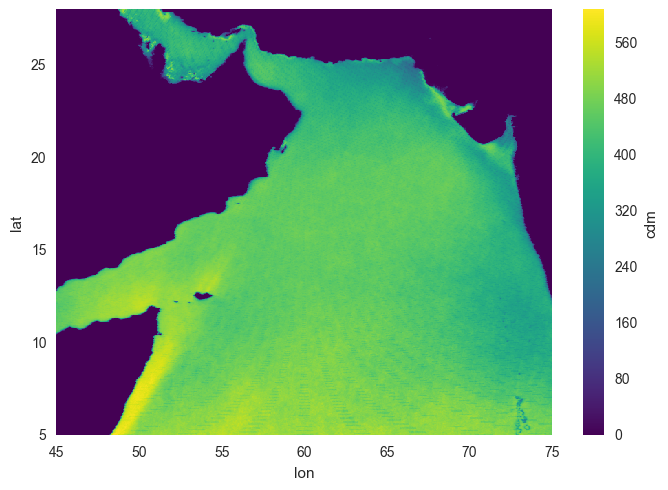

In [10]:
# Count the number of ocean data points
(ds_8day.cdm>0).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive


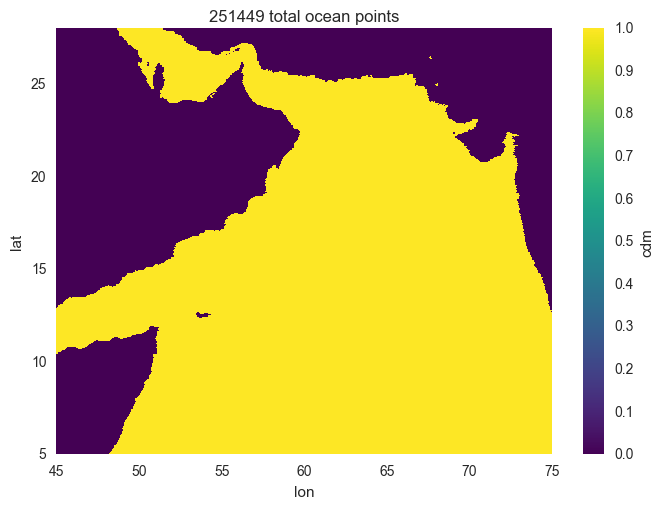

In [11]:
#  find a mask for the land
ocean_mask = (ds_8day.cdm>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


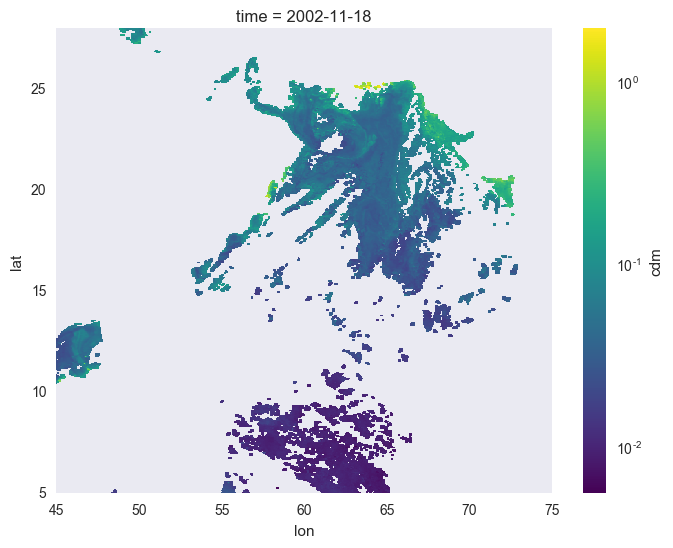

In [12]:
plt.figure(figsize=(8,6))
ds_daily.cdm.sel(time='2002-11-18',method='nearest').plot(norm=LogNorm())

In [13]:
ds_daily.groupby('time').count() # information from original data

<xarray.Dataset>
Dimensions:  (time: 5536)
Coordinates:
  * time     (time) datetime64[ns] 2002-04-28 2002-04-29 2002-04-30 ...
Data variables:
    cdm      (time) int64 57222 47678 55871 36421 34222 51208 17634 16960 ...

In [14]:
ds_daily.cdm.groupby('time').count()/float(num_ocean_points)

<xarray.DataArray 'cdm' (time: 5536)>
array([ 0.227569,  0.189613,  0.222196, ...,  0.000414,  0.020235,  0.027401])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-28 2002-04-29 2002-04-30 ...

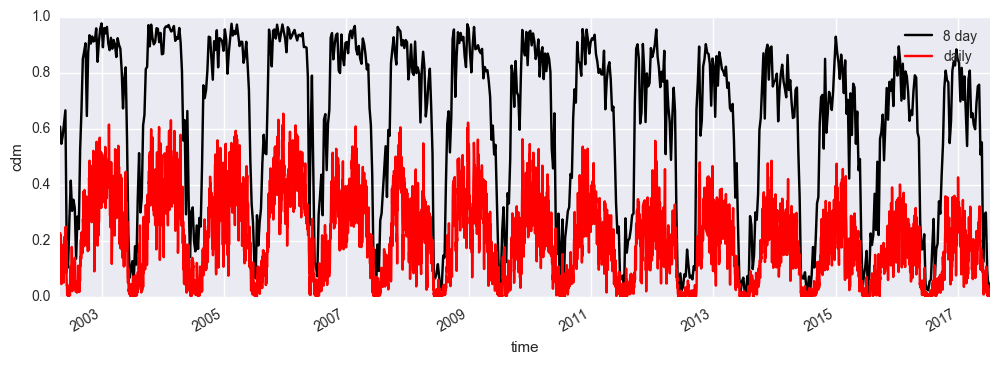

In [15]:
count_8day,count_daily = [ds.cdm.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day,ds_daily)]

plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')

plt.legend(['8 day','daily'])

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


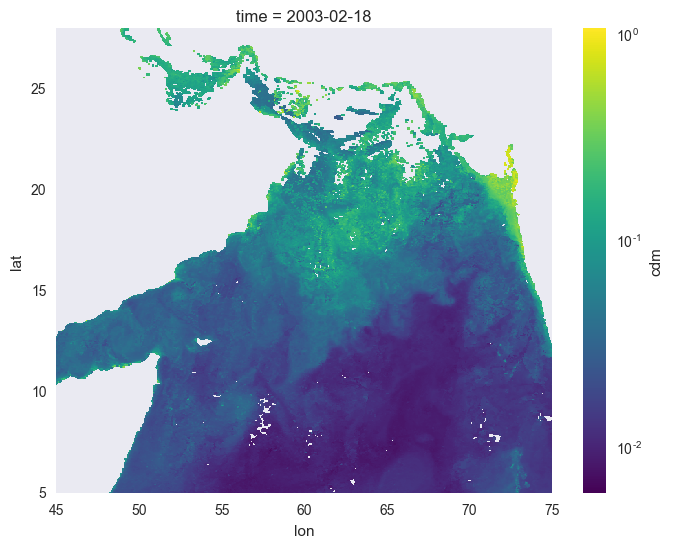

In [16]:
# Maps of individual days
target_date = '2003-02-15'
plt.figure(figsize=(8,6))
ds_8day.cdm.sel(time=target_date, method='nearest').plot(norm=LogNorm())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


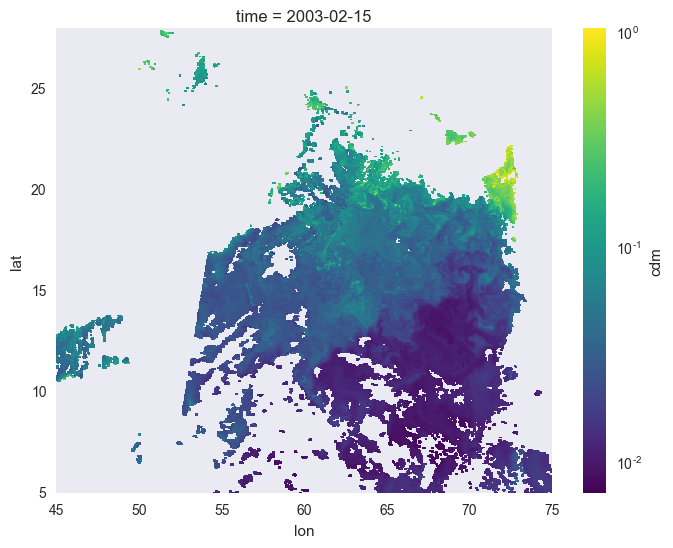

In [17]:
plt.figure(figsize=(8,6))
ds_daily.cdm.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [43]:
freq

5

In [44]:
# next carry out interpolation starts here
freq_resample = str(freq) + 'D'
ds_resample = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_resample

<xarray.Dataset>
Dimensions:  (lat: 553, lon: 721, time: 1111)
Coordinates:
  * lat      (lat) float32 28.0208 27.9792 27.9375 27.8958 27.8542 27.8125 ...
  * lon      (lon) float32 44.9792 45.0208 45.0625 45.1042 45.1458 45.1875 ...
  * time     (time) datetime64[ns] 2002-04-28 2002-05-03 2002-05-08 ...
Data variables:
    cdm      (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


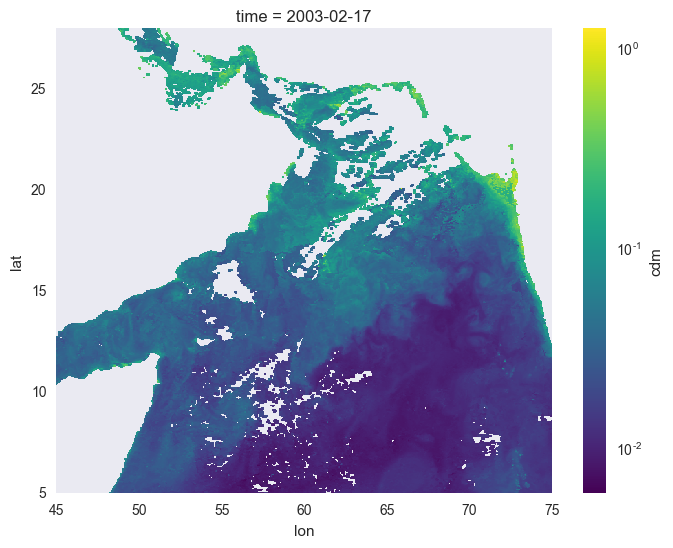

In [45]:
plt.figure(figsize=(8,6))
ds_resample.cdm.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [46]:
# check the range for the longitude
print(ds_resample.lon.min(),'\n' ,ds_resample.lat.min())  

<xarray.DataArray 'lon' ()>
array(44.97917175292969) 
 <xarray.DataArray 'lat' ()>
array(5.020830154418945)


# ++++++++++++++++++++++++++++++++++++++++++++++
# All GDP Floats
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

In [47]:
# load preprocessed float data, and start the interpolation right here!!!!
var1 = "chl"
vardist = "dist"
indir_prefix = "./data_globcolour/output.data.interpolate/" + "df_Globcolor_"
indir = indir_prefix + var1 + vardist + "_" + str(freq) + "d.csv"

floatDF_tmp = pd.read_csv(indir,index_col=0)
print(floatDF_tmp)

              id        time        lat        lon       temp         ve  \
1096       10206  2002-07-04  16.190700  66.437550        NaN   8.431050   
2192       10208  2002-07-04  13.701700  69.680000        NaN  11.618100   
3288       11089  2002-07-04  16.283100  64.832700  27.860900  13.125650   
4384       15703  2002-07-04  13.718200  69.702450  28.561050  11.283150   
6576       27069  2002-07-04  20.155600  69.060600  28.943050  26.055900   
8768       28842  2002-07-04  18.768700  60.796300  27.671700   6.222250   
9864       34159  2002-07-04  12.634550  59.215600        NaN  27.171650   
12056      34210  2002-07-04   6.252450  56.814650  26.721500 -12.819450   
13152      34211  2002-07-04   8.417400  68.184050  28.352650  22.853000   
14248      34212  2002-07-04   6.461400  65.182500  28.524600  38.186550   
23016      34708  2002-07-04  10.205150  60.171300  27.165850  40.137400   
25208      34710  2002-07-04  13.235250  50.023700  31.061350   8.344300   
26304      3

In [48]:
from tools.time_lat_lon_interpolate import interpolate
importlib.reload(interpolate)


result_out5 = interpolate.sel_points_multilinear_time_lat_lon(ds_resample, floatDF_tmp, dims = 'points', col_name ='cdm')
print('\n *** after the interpolation *** \n', result_out5)
# important: keep the id, since the dataframe has been modified in a bound-aware way in the function
print('\n *** this two length should be equal *** %d >= %d?' %(len(floatDF_tmp.index), len(result_out5.index) ) )  


 *** after the interpolation *** 
               id        time        lat        lon       temp         ve  \
1096       10206  2002-07-04  16.190700  66.437550        NaN   8.431050   
2192       10208  2002-07-04  13.701700  69.680000        NaN  11.618100   
3288       11089  2002-07-04  16.283100  64.832700  27.860900  13.125650   
4384       15703  2002-07-04  13.718200  69.702450  28.561050  11.283150   
6576       27069  2002-07-04  20.155600  69.060600  28.943050  26.055900   
8768       28842  2002-07-04  18.768700  60.796300  27.671700   6.222250   
9864       34159  2002-07-04  12.634550  59.215600        NaN  27.171650   
12056      34210  2002-07-04   6.252450  56.814650  26.721500 -12.819450   
13152      34211  2002-07-04   8.417400  68.184050  28.352650  22.853000   
14248      34212  2002-07-04   6.461400  65.182500  28.524600  38.186550   
23016      34708  2002-07-04  10.205150  60.171300  27.165850  40.137400   
25208      34710  2002-07-04  13.235250  50.023700  

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


              id        time        lat        lon       temp         ve  \
1096       10206  2002-07-04  16.190700  66.437550        NaN   8.431050   
2192       10208  2002-07-04  13.701700  69.680000        NaN  11.618100   
3288       11089  2002-07-04  16.283100  64.832700  27.860900  13.125650   
4384       15703  2002-07-04  13.718200  69.702450  28.561050  11.283150   
6576       27069  2002-07-04  20.155600  69.060600  28.943050  26.055900   
8768       28842  2002-07-04  18.768700  60.796300  27.671700   6.222250   
9864       34159  2002-07-04  12.634550  59.215600        NaN  27.171650   
12056      34210  2002-07-04   6.252450  56.814650  26.721500 -12.819450   
13152      34211  2002-07-04   8.417400  68.184050  28.352650  22.853000   
14248      34212  2002-07-04   6.461400  65.182500  28.524600  38.186550   
23016      34708  2002-07-04  10.205150  60.171300  27.165850  40.137400   
25208      34710  2002-07-04  13.235250  50.023700  31.061350   8.344300   
26304      3

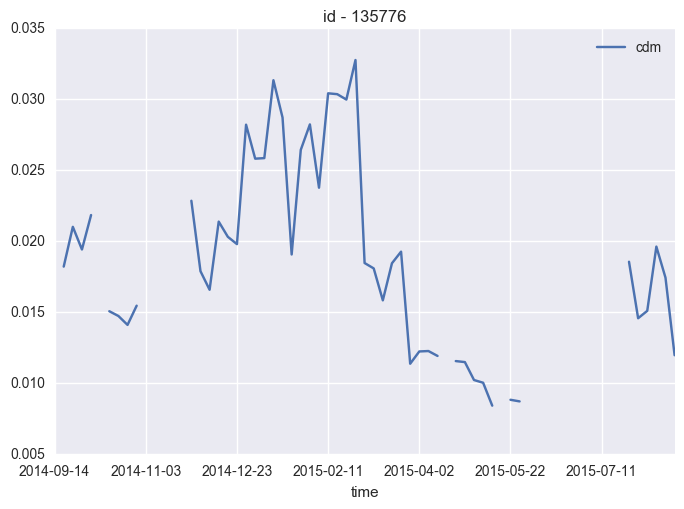

In [49]:
# output the dataframe result_out4
var2 = "cdm"
var_dist = "dist"
outdir_prefix = "./data_globcolour/output.data.interpolate/" + "df_Globcolor_"
outdir = outdir_prefix + var1 + var_dist + var2 + "_" + str(freq) + "d.csv"
result_out5.to_csv(outdir)
print(pd.read_csv(outdir,index_col=0))

### plot for id 125776, which will be fit by LDS
plt.figure(figsize=(8,6))
result_out5[result_out5.id == 135776].plot(x='time', y ='cdm', title=('id - %d' % 135776) )
plt.show();
plt.close("all")